In [1]:
import qlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import statsmodels.api as sm
from qlib.data import D
from qlib.config import REG_CN
from qlib.contrib.data.handler import Alpha158
from qlib.data.filter import NameDFilter, ExpressionDFilter
from qlib.contrib.model.gbdt import LGBModel
from qlib.contrib.data.handler import Alpha158
from qlib.utils import init_instance_by_config, flatten_dict
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).


In [ ]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/day1_data_qlib', region=REG_CN)
expressionDFilter = ExpressionDFilter(rule_expression='$volume != 0')
instruments = D.instruments(market = 'all', filter_pipe=[expressionDFilter])
new = D.features(instruments = instruments, fields = ['$new'], start_time = '2022-01-01', end_time = '2025-06-20', freq = 'day').unstack().T.droplevel(0)
ST = D.features(instruments = instruments, fields = ['$ST'], start_time = '2022-01-01', end_time = '2025-06-20', freq = 'day').unstack().T.droplevel(0)
marketcap = D.features(instruments = instruments, fields = ['$marketcap'], start_time = '2022-01-01', end_time = '2025-06-20', freq = 'day').unstack().T.droplevel(0)
yjl = D.features(instruments = instruments, fields = ['$CONVERTIBLEPREMIUMRATE'], start_time = '2022-01-01', end_time = '2025-06-20', freq = 'day').unstack().T.droplevel(0)
data_close = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-06-20', freq = 'day').unstack().T.droplevel(0)
data_open = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-06-20', freq = 'day').unstack().T.droplevel(0)
QS = pd.read_csv('C:/Users/tantra/Desktop/数据/CBredeem.csv').pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
# stock_list = D.list_instruments(instruments = instruments,
#                                 start_time='2022-01-01',
#                                 end_time='2025-03-31',
#                                 as_list=True)

[56628:MainThread](2025-07-02 17:28:34,904) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[56628:MainThread](2025-07-02 17:28:34,909) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[56628:MainThread](2025-07-02 17:28:34,916) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/day1_data_qlib')}


In [31]:
OVD = pd.read_csv('C:/Users/tantra/Desktop/数据/Fund_allValueDev.csv')
OVD = OVD.pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
OVD.index = pd.to_datetime(OVD.index)
OVD = OVD.loc['2022-01-01':'2025-6-20'].dropna(how='all', axis=1)
#纯债溢价率
SPR = pd.read_csv('C:/Users/tantra/Desktop/数据/Fund_StrbPremiumRate.csv')
SPR = SPR.pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
SPR.index = pd.to_datetime(SPR.index)
SPR = SPR.loc['2022-01-01':'2025-6-20'].dropna(how='all', axis=1)

In [3]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/min1_data_qlib', region=REG_CN)
instruments = D.instruments(market = 'all')

[34728:MainThread](2025-07-01 15:03:36,707) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[34728:MainThread](2025-07-01 15:03:36,711) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[34728:MainThread](2025-07-01 15:03:36,711) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/min1_data_qlib')}


In [ ]:
# 剔除当天正股为ST股的可转债的因子值,factor为dict格式
def exclude_ST(factor):
    for date in factor.keys():
        dates = date[:-2]
        factor[date] = factor[date][ST.loc[dates] == 0]
    return factor

# 剔除当天为新债的可转债的因子值，factor为dict格式
def exclude_newbond(factor):
    for date in factor.keys():
        dates = date[:-2]
        factor[date] = factor[date][new.loc[dates] == 0]
    return factor

# 剔除当天为强赎的可转债的因子值，factor为dict格式
def exclude_QS(factor):
    for date in factor.keys():
        dates = date[:-2]
        factor[date] = factor[date][QS.loc[dates] == 0]
    return factor

# 缩尾处理将超过分位数的因子替换为边界值,factor为dict格式，low为下分位数，up为上分位数
def winsorize(factor,low = 0.01, up = 0.99):
    for date in factor.keys():
        s = factor[date].copy()
        lower = s.quantile(low)
        upper = s.quantile(up)
        factor[date] = s.clip(lower, upper)
    return factor

# 标准化处理,factor为dict格式
def factor_std(factor):
    for date in factor.keys():
        factor[date] = (factor[date] - factor[date].mean()) / factor[date].std()
    return factor

# 缩尾和标准化，factor为dataframe格式，返回dataframe格式
def win_std(factor):
    return pd.DataFrame(factor_std(winsorize(factor_dict(factor)))).T

# 将dataframe格式的因子数据表变为dict格式,
def factor_dict(factor):
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    return factor_dict

# 对溢价率中性化,factor为dict格式
def net_yjl(factor):
    data_yjl = factor_dict(yjl)
    for date in factor.keys():
        y = factor[date].dropna()
        x = data_yjl[date].dropna()
        x, y = x.align(y, join='inner')
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 对市值中性化,factor为dict格式
def net_marketcap(factor):
    data_marketcap = factor_dict(marketcap)
    for date in factor.keys():
        y = factor[date].dropna()
        x = data_marketcap[date].dropna()
        x, y = x.align(y, join='inner')
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 对因子中性化，factor1为需要被中性化的因子，factor1为dataframe格式,factor_list为需要对其中性化的因子变量列表，列表中每一个变量是dataframe格式
def net_factor(factor1, factor_list):
    date_list = factor1.index
    for i in factor_list:
        date_list = date_list.intersection(i.index)
    factor = {}
    for date in date_list:
        factor_x = pd.DataFrame()
        for i in factor_list: 
            factor_x = pd.concat([factor_x, i.loc[date]], axis=1) 
        y = factor1.loc[date].dropna()
        x = factor_x.dropna()
        x, y = x.align(y, join='inner', axis=0)
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 制作相关系数矩阵,factor_list为因子变量的列表，每个元素为dataframe格式的因子，factor_name为因子名字符串的列表
def cal_corr_matrix(factor_list, factor_name):
    dict_factor = dict(zip(factor_name, factor_list))
    corr_matrix = pd.DataFrame(columns=factor_name, index=factor_name)
    for factor1 in factor_name:
        for factor2 in factor_name:
            corr_matrix.loc[factor1, factor2] = dict_factor[factor1].loc['2023-01-01':].corrwith(dict_factor[factor2].loc['2023-01-01':], axis=1).mean()
    return corr_matrix


In [ ]:
# 计算因子每日分组收益率,N为分组数,factor为dict格式
def cal_group_return(factor, N):
    date_list = list(factor.keys())
    group_return={}
    if cal_RankIC_mean(factor) > 0:
        for date in date_list[:-1]:
            factor[date] = factor[date].dropna()
            stock_all = factor[date].index.tolist()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_close_part.shift(-1)/data_close_part - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group'+str(N)] - stock_return['group1']
            stock_return['benchmark'] = (data_close_part.loc[:,stock_all].shift(-1)/data_close_part.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    else:
        for date in date_list[:-1]:
            factor[date] = factor[date].dropna()
            stock_all = factor[date].index.tolist()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_close_part.shift(-1)/data_close_part - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group1'] - stock_return['group'+str(N)]
            stock_return['benchmark'] = (data_close_part.loc[:,stock_all].shift(-1)/data_close_part.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    return group_return

In [ ]:
# 计算分组每期换手率,factor为dict格式
def cal_group_turnover(factor, N):
    turnover = pd.DataFrame()
    for i in range(1,N+1):
        stock_amount = {}
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[int(len(factor[time].dropna())/N*(i-1)):int(len(factor[time].dropna())/N*i)].index)
        stock_amount = pd.Series(stock_amount)
        turnover_rate = pd.Series(index=stock_amount.index, name=f'group{i}')
        for i in range(1,len(stock_amount)):
            prev_set = stock_amount[i-1]
            current_set = stock_amount[i]
            new_elements = len(current_set - prev_set)
            try:
                turnover_rate[i] = new_elements / len(prev_set)
            except:
                turnover_rate[i] = 0
        turnover = pd.concat([turnover,turnover_rate], axis=1)
    return turnover

# 画出分组累积超额收益走势，factor为dict格式，N为组数
def plot_return(factor, N, turnover=0.0001):
    group_return = cal_group_return(factor, N)
    group_cum_return = pd.DataFrame(group_return).T.shift(1)
    group_turnover = cal_group_turnover(factor,N)
    for i in range(1,N+1):
        group_cum_return['group'+str(i)] = group_cum_return['group'+str(i)] - group_cum_return['benchmark'] - group_turnover['group'+str(i)] * turnover
    group_cum_return.iloc[0] = 0
    group_cum_return = group_cum_return.dropna(how='all')
    group_cum_return.cumsum().iloc[:,:N+1].plot()

# 计算年化收益率，factor为dict格式，N为组数
def cal_annual_return(factor, N):
    return (pd.DataFrame(cal_group_return(factor, N)).T).mean() * 504

# 计算每日RankIC值，factor为dict格式
def cal_RankIC(factor):
   factor = pd.DataFrame(factor)
   return factor.corrwith((data_close_part.shift(-1)/data_close_part-1).T, method = 'spearman')

# 计算每日RankIC均值，factor为dict格式
def cal_RankIC_mean(factor):
    RankIC = cal_RankIC(factor).mean()
    return RankIC

# 计算日度RankICIR值，factor为dict格式
def cal_RankICIR(factor):
    RankIC = cal_RankIC(factor)
    ICIR = RankIC.mean() / RankIC.std()
    return ICIR

# 计算分组累积超额收益,factor为dict格式,N为组数
def cal_alpha(factor, N):
    group_return = cal_group_return(factor, N)
    group_return = pd.DataFrame(group_return).T
    group_return_cumprod = (group_return + 1).cumprod()
    excess_Return = group_return_cumprod.sub(group_return_cumprod['benchmark'], axis = 0)
    return excess_Return.iloc[:,:-1]

# 计算多头年化超额,factor为dict格式，N为组数
def cal_long_return(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].mean() * 252
        return long
    
# 计算多头超额胜率,factor为dict格式，N为组数
def cal_long_winrate(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    
# 计算年化夏普比率,factor为dict格式，N为组数，rate为无风险利率
def cal_sharp(factor, N, rate=0.02):
    annual_return = cal_annual_return(factor, N) - rate
    std = pd.DataFrame(cal_group_return(factor, N)).T.std() * math.sqrt(504)
    sharp = annual_return / std 
    return sharp

# 计算概率，factor为dict格式，N为组数
def cal_probability(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T.iloc[:,:-1]
    group_return = group_return.rolling(20).sum().dropna(how = 'all')
    group_cols = [col for col in group_return.columns[:N]]
    if cal_RankIC_mean(factor) < 0:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[0]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] >= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    else:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[0]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] <= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    n = len(group_return.index)
    p0, p1, p2, p3 = group_return['概率0'].sum()/n, group_return['概率1'].sum()/n, group_return['概率2'].sum()/n, group_return['概率3'].sum()/n
    return pd.Series([p0,p1,p2,p3],index = ['概率0','概率1','概率2','概率3'])

In [ ]:
# 计算多头每期换手率,factor为dict格式
def cal_turnover(factor, N):
    stock_amount = {}
    if cal_RankIC_mean(factor) < 0:
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[:int(len(factor[time].dropna())/N)].index)
    else:
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[int(len(factor[time].dropna())/N*(N-1)):].index)
    stock_amount = pd.Series(stock_amount)
    turnover_rate = pd.Series(index=stock_amount.index)
    for i in range(1,len(stock_amount)):
        prev_set = stock_amount[i-1]
        current_set = stock_amount[i]
        new_elements = len(current_set - prev_set)
        try:
            turnover_rate[i] = new_elements / len(prev_set)
        except:
            turnover_rate[i] = 0
    return turnover_rate

# 计算多头每日平均换手率，factor为dict格式
def cal_turnover_mean(factor, N):
    turnover_rate = cal_turnover(factor, N)
    grouped = turnover_rate.groupby(turnover_rate.index.map(lambda x: x[:-2])).sum()
    return grouped[1:].mean()

In [ ]:
# 计算多头年化超额（考虑换手率）,factor为dict格式，N为组数
def cal_long_return_turnover(factor, N, turnover=0.0001):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group'+str(N)] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group1'] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].mean() * 252
        return long
    
# 计算多头超额胜率（考虑换手率）,factor为dict格式，N为组数    
def cal_long_winrate_turnover(factor, N, turnover=0.0001):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group'+str(N)] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group1'] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate

In [ ]:
# 分池，factor为dataframe格式
def cal_pool_factor(factor):
    mark = pd.read_csv('C:/Users/tantra/Desktop/数据/CBStyleMark.csv', parse_dates=['date'])
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    pools = ['GP','ZP','DP']
    for pool in pools:
        if pool == 'GP':
            factor_day_GP = {}
            for date in factor_dict.keys():
                dates = date[:-2]
                mark1 = mark[mark['date'] == dates]
                mark1 = mark1[mark1['GP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_GP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'ZP':
            factor_day_ZP = {}
            for date in factor_dict.keys():
                dates = date[:-2]
                mark1 = mark[mark['date'] == dates]
                mark1 = mark1[mark1['ZP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_ZP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'DP':
            factor_day_DP = {}
            for date in factor_dict.keys():
                dates = date[:-2]
                mark1 = mark[mark['date'] == dates]
                mark1 = mark1[mark1['DP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_DP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
    return factor_day_GP,factor_day_ZP,factor_day_DP

In [10]:
# 分池因子分析，factor为dataframe格式，N为组数
def factor_analyse(factor, st=True, new=True, qs=True, yjl=False, mar=False, win=True, std=True, N1=3, N2=4, N3=3):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额', '多头超额胜率', '多空夏普比率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc['2023-01-03p1':'2024-06-28p2']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if qs:
                factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc['2024-07-01p1':'2024-12-31p2']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if qs:
                factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc['2025-01-02p1':'2025-06-20p2']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if qs:
                factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df

In [11]:
# 分池因子分析（考虑换手），factor为dataframe格式，N为组数
def factor_analyse_turnover(factor, st=True, new=True, qs=True, yjl=False, mar=False, win=True, std=True, N1=3, N2=4, N3=3):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额（换手）', '多头超额胜率（换手）', '日均换手率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc['2023-01-03p1':'2024-06-28p2']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if qs:
                factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc['2024-07-01p1':'2024-12-31p2']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if qs:
                factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc['2025-01-02p1':'2025-06-20p2']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if qs:
                factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df

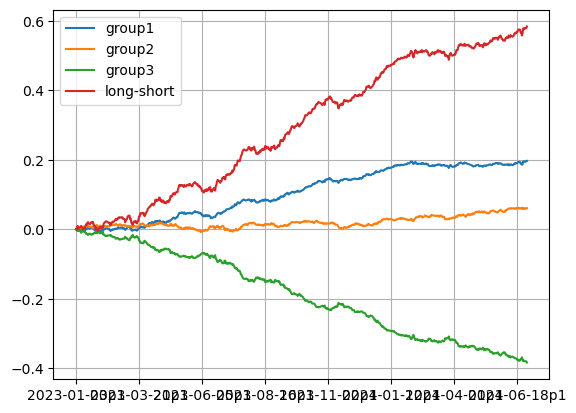

In [444]:
# 样本内
ret5_test = combined_factor.loc['2023-01-03p1':'2024-06-28p2']
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
plot_return(factor_gp, 3)
# plot_return(factor_zp, 6)
# plot_return(factor_dp, 3)
plt.grid(True)

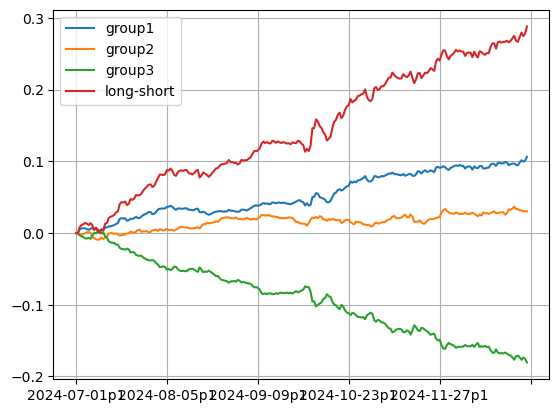

In [445]:
# 样本外
ret5_test = combined_factor.loc['2024-07-01p1':'2024-12-31p2']
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
# plot_return(factor_dp, 3)
plt.grid(True)

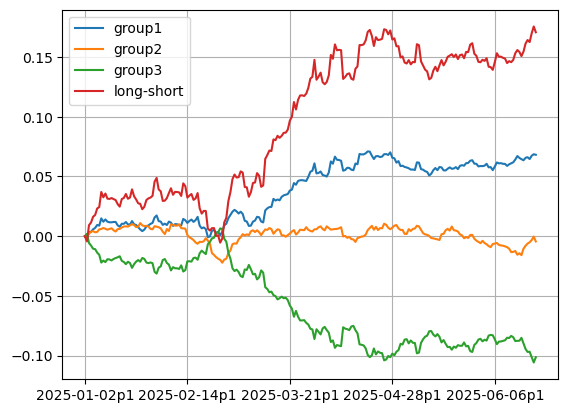

In [644]:
# 测试期
ret5_test = combined_factor.loc['2025-01-02p1':'2025-6-20p2']
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
# plot_return(factor_dp, 3)
plt.grid(True)

In [448]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)

In [12]:
data_open_min = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-06-23', freq = '1min').unstack().T.droplevel(0)
data_high_min = D.features(instruments = instruments, fields = ['$high'], start_time = '2022-01-01', end_time = '2025-06-23', freq = '1min').unstack().T.droplevel(0)
data_low_min = D.features(instruments = instruments, fields = ['$low'], start_time = '2022-01-01', end_time = '2025-06-23', freq = '1min').unstack().T.droplevel(0)
data_close_min = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-06-23', freq = '1min').unstack().T.droplevel(0)
data_volume_min = D.features(instruments = instruments, fields = ['$volume'], start_time = '2022-01-01', end_time = '2025-06-23', freq = '1min').unstack().T.droplevel(0)
data_amount_min = D.features(instruments = instruments, fields = ['$amount'], start_time = '2022-01-01', end_time = '2025-06-23', freq = '1min').unstack().T.droplevel(0)
data_amount_min.loc['2025-3-19'] = data_close_min.loc['2025-3-19'] * data_volume_min.loc['2025-3-19']
data_amount_min.loc['2025-3-20'] = data_close_min.loc['2025-3-20'] * data_volume_min.loc['2025-3-20']
data_amount_min.loc['2025-3-21'] = data_close_min.loc['2025-3-21'] * data_volume_min.loc['2025-3-21']

In [13]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-6-20'].index]
for date in date_list:
    data_close_min.loc[date] = data_close_min.loc[date].fillna(method = 'ffill')

In [14]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-6-20'].index]
for date in date_list:
    data_open_min.loc[date] = data_open_min.loc[date].fillna(method = 'ffill')

In [15]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-6-20'].index]
time_list = []
for date in date_list:
    time_list = time_list + [date + 'p1', date + 'p2']

In [32]:
data_close_part = {}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=13, minutes=1)
        data_close_part[time] = data_open_min.loc[target_datetime]
    if time.endswith('p2'):
        try:
            target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
            data_close_part[time] = data_close_min.loc[target_datetime]
        except:
            data_close_part[time] = data_close_min.loc[date].iloc[0]
data_close_part = pd.DataFrame(data_close_part).T

data_open_part = {}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        try:
            target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
            data_open_part[time] = data_open_min.loc[target_datetime]
        except:
            data_open_part[time] = data_open_min.loc[date].iloc[0]
    if time.endswith('p2'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=13, minutes=1)
        data_open_part[time] = data_open_min.loc[target_datetime]
data_open_part = pd.DataFrame(data_open_part).T

In [ ]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-6-20'].index]

data_compare_True = data_close_min.copy()
for date in date_list:
    data_compare_True.loc[date] = data_close_min.loc[date] > data_close_min.loc[date].shift(1)

data_compare_False = data_close_min.copy()
for date in date_list:
    data_compare_False.loc[date] = data_close_min.loc[date] <= data_close_min.loc[date].shift(1)

In [425]:
data_compare_True.to_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv')
data_compare_False.to_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv')


In [17]:
data_compare_True = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv', parse_dates=['datetime'], index_col='datetime')
data_compare_False = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv', parse_dates=['datetime'], index_col='datetime')

In [33]:
# 成交量比率合成因子
# date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-3-28'].index]

# data_compare_True = data_close_min.copy()
# for date in date_list:
#     data_compare_True.loc[date] = data_close_min.loc[date] > data_close_min.loc[date].shift(1)

# data_compare_False = data_close_min.copy()
# for date in date_list:
#     data_compare_False.loc[date] = data_close_min.loc[date] <= data_close_min.loc[date].shift(1)

# data_compare_True = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv', parse_dates=['datetime'], index_col='datetime')
# data_compare_False = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv', parse_dates=['datetime'], index_col='datetime')

# drop_index =[]
# for date in date_list:
#     drop_index.extend([data_compare_True.loc[date].index[0], data_compare_True.loc[date].index[-1]])
# data_compare_True.drop(index = drop_index, inplace = True)
# data_compare_False.drop(index = drop_index, inplace = True)

factor = {}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        factor[time] = data_volume_min.loc[begain_time:end_time][data_compare_True.loc[begain_time:end_time]].dropna(how='all', axis=1).sum() / data_volume_min.loc[begain_time:end_time][data_compare_False.loc[begain_time:end_time]].dropna(how='all', axis=1).sum()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        factor[time] = data_volume_min.loc[begain_time:end_time][data_compare_True.loc[begain_time:end_time]].dropna(how='all', axis=1).sum() / data_volume_min.loc[begain_time:end_time][data_compare_False.loc[begain_time:end_time]].dropna(how='all', axis=1).sum()
factor= pd.DataFrame(factor).T 
factor1 = factor
factor1.dropna(how='all', axis=1, inplace=True)
factor1 = factor1.replace([np.inf, -np.inf], np.nan)
# def weight_sum(series, N=2):
#     weight = 1 / (sum(range(1,N+1)) / N)
#     weight = pd.Series(range(1,N+1), index = series.index) * weight / N
#     return (series * weight).sum()

# factor_1 = factor_dict(factor.rolling(10).mean())
# factor_2 = factor_dict(factor.rolling(2).apply(weight_sum))
# # 合成因子,factor1、factor2为dict格式
# def factor_combine(factor1, factor2, n1, n2):
#     factor1 = winsorize(factor1)
#     factor2 = winsorize(factor2)
#     factor1 = factor_std(factor1)
#     factor2 = factor_std(factor2)
#     factor1 = pd.DataFrame(factor1).T
#     factor2 = pd.DataFrame(factor2).T
#     conbined_factor = n1 * factor1 + n2 * factor2
#     return conbined_factor

# factor1 = factor_combine(factor_1, factor_2, 0.3, 0.7)
# factor1.dropna(how='all', inplace=True)

In [34]:
# # 估波指标
# def cal_factor(series):
#     R1 = series / series.shift(1) - 1
#     R2 = series / series.shift(2) - 1
#     RC = R1 + R2
#     return RC.mean()

factor2 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        R1 = data / data.shift(1) - 1
        R2 = data / data.shift(2) - 1
        factor2[time] = (R1 + R2).mean()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        data = data_close_min.loc[begain_time:end_time]
        R1 = data / data.shift(1) - 1
        R2 = data / data.shift(2) - 1
        factor2[time] = (R1 + R2).mean()
factor2 = pd.DataFrame(factor2).T

# def weight_sum(series, N=3):
#     weight = 1 / (sum(range(1,N+1)) / N)
#     weight = pd.Series(range(1,N+1), index=series.index) * weight / N
#     return (series * weight).sum()

# factor2 = factor_new.rolling(3).apply(weight_sum)
# factor2.dropna(how='all', inplace=True)

In [35]:
factor3 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        factor_value = return_std_std.corrwith(data_amount_min)
        factor3[time] = factor_value
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        data = data_close_min.loc[begain_time:end_time]
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        factor_value = return_std_std.corrwith(data_amount_min)
        factor3[time] = factor_value
factor3 = pd.DataFrame(factor3).T

In [36]:
factor4 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        data_abs = np.abs(data - data.shift(1))
        SU = data_abs[data_compare_True.loc[begain_time:end_time]].sum()
        SD = data_abs[data_compare_False.loc[begain_time:end_time]].sum()
        factor4[time] = (SU - SD) / (SU + SD)
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        data = data_close_min.loc[begain_time:end_time]
        data_abs = np.abs(data - data.shift(1))
        SU = data_abs[data_compare_True.loc[begain_time:end_time]].sum()
        SD = data_abs[data_compare_False.loc[begain_time:end_time]].sum()
        factor4[time] = (SU - SD) / (SU + SD)
factor4 = pd.DataFrame(factor4).T

In [37]:
# # 模糊金额比因子
# def cal_factor(series):
#     series = series[1:-1]
#     min_index = series.index
#     return_min = series / series.shift(1) - 1
#     return_std = return_min.rolling(5).std()
#     return_std_std = return_std.rolling(5).std()
#     return_std_std_mean = return_std_std.mean()
#     return data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()

factor5 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        min_index = data.index
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        return_std_std_mean = return_std_std.mean()
        factor5[time] = data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        data = data_close_min.loc[begain_time:end_time]
        min_index = data.index
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        return_std_std_mean = return_std_std.mean()
        factor5[time] = data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()
factor5 = pd.DataFrame(factor5).T

In [38]:
factor6 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        close_max = data.rolling(2).max()
        factor6[time] = ((data - data.shift(1)) / close_max).mean()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        data = data_close_min.loc[begain_time:end_time]
        close_max = data.rolling(2).max()
        factor6[time] = ((data - data.shift(1)) / close_max).mean()
factor6 = pd.DataFrame(factor6).T

In [39]:
# 动态买卖气指标
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-6-20'].index]

data_compare_DTM = data_open_min > data_open_min.shift(1)
data_compare_DBM = data_open_min >= data_open_min.shift(1)

drop_index =[]
for date in date_list:
    drop_index.extend([data_compare_DTM.loc[date].index[0], data_compare_DTM.loc[date].index[-1]])

data_compare_DTM.drop(index = drop_index, inplace = True)
data_compare_DBM.drop(index = drop_index, inplace = True)

factor7 ={}
HO = data_high_min - data_open_min
OO = data_open_min - data_open_min.shift(1)
OL = data_open_min - data_low_min
DTM = np.maximum(HO,OO)[data_compare_DTM]
DBM = np.maximum(OL,OO)[data_compare_DBM]
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        STM = DTM.loc[begain_time:end_time].sum()
        SBM = DBM.loc[begain_time:end_time].sum()
        factor7[time] = (STM - SBM) / np.maximum(STM,SBM)
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        STM = DTM.loc[begain_time:end_time].sum()
        SBM = DBM.loc[begain_time:end_time].sum()
        factor7[time] = (STM - SBM) / np.maximum(STM,SBM)
factor7 = pd.DataFrame(factor7).T

In [40]:
factor9 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        high_low = data_high_min.loc[begain_time:end_time] - data_low_min.loc[begain_time:end_time]
        close_high = data_close_min.loc[begain_time:end_time].shift(1) - data_high_min.loc[begain_time:end_time]
        abs_close_low = np.abs(data_close_min.loc[begain_time:end_time].shift(1) - data_low_min.loc[begain_time:end_time])
        atr = np.maximum(np.maximum(high_low, close_high), abs_close_low)
        ATR = atr.iloc[1:-1].mean()
        factor9[time] = ATR
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=50)
        high_low = data_high_min.loc[begain_time:end_time] - data_low_min.loc[begain_time:end_time]
        close_high = data_close_min.loc[begain_time:end_time].shift(1) - data_high_min.loc[begain_time:end_time]
        abs_close_low = np.abs(data_close_min.loc[begain_time:end_time].shift(1) - data_low_min.loc[begain_time:end_time])
        atr = np.maximum(np.maximum(high_low, close_high), abs_close_low)
        ATR = atr.iloc[1:-1].mean()
        factor9[time] = ATR
factor9 = pd.DataFrame(factor9).T

In [136]:
factor1_net = pd.DataFrame(net_factor(factor1.reindex(yjl_factor.index),[yjl_factor])).T
factor_analyse(factor1_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.231870 -0.400154 -0.467698 -0.227150 -0.444995 -0.412896   
多头年化超额    0.044755  0.066247  0.062653  0.158627  0.059042  0.011993   
多头超额胜率    0.516760  0.625698  0.625698  0.629032  0.612903  0.548387   
多空夏普比率    1.638391  3.393768  3.161214  2.503944  2.951741  0.494577   
概率1       0.592593  0.441799  0.544974  0.454545  0.474026  0.370130   
概率2       0.330688  0.304233  0.547619  0.564935  0.402597  0.318182   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.265241 -0.546322 -0.616668  
多头年化超额    0.045080  0.072021  0.046211  
多头超额胜率    0.354545  0.418182  0.400000  
多空夏普比率    1.809530  7.460088  7.032679  
概率1       0.396694  0.785124  0.925620  
概率2       0.380165  0.396694  0.636364

In [72]:
def weight_sum(series, N=6):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_2 = factor2.rolling(6).apply(weight_sum).dropna(how='all')
factor_4 = factor4.rolling(6).apply(weight_sum).dropna(how='all')
factor_6 = factor6.rolling(6).apply(weight_sum).dropna(how='all')

In [89]:
#factor1_std = factor_std(winsorize(factor_dict(factor1)))
factor2_std = factor_std(winsorize(factor_dict(factor_2)))
factor4_std = factor_std(winsorize(factor_dict(factor_4)))
factor6_std = factor_std(winsorize(factor_dict(factor_6)))
# factor3_std = factor_std(winsorize(factor_dict(factor_3)))
# factor5_std = factor_std(winsorize(factor_dict(factor_5)))
# factor9_std = factor_std(winsorize(factor_dict(factor9_net)))

In [ ]:
p1_index = [x for x in factor1.index if x.endswith('p1')]
p2_index = [x for x in factor1.index if x.endswith('p2')]
factor1.loc[p2_index]

In [480]:
cal_corr_matrix([factor1, factor2, factor3, factor4, factor5, factor6, factor7, factor9],['factor1','factor2','factor3','factor4','factor5','factor6','factor7','factor9'])#['成交量比率', '估波指标', '模糊金额比', '动量修正', '钱德动量摆动'] )#['溢价率', '期权价值偏移', '纯债溢价率', '成交量比率合成因子', '估波指标', '模糊金额比', '随波逐流'])

,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor9
factor1,1.0,0.316187,0.09801,0.45416,0.093209,0.320053,0.224985,0.143659
factor2,0.314789,1.0,0.056689,0.689856,0.145139,0.977545,0.232334,0.082618
factor3,0.098219,0.056689,1.0,0.056419,0.643621,0.055941,0.122782,0.314907
factor4,0.452499,0.689856,0.056419,1.0,0.107372,0.715708,0.292077,0.03785
factor5,0.0927,0.145139,0.643621,0.107372,1.0,0.137668,0.109666,0.121185
factor6,0.318566,0.977545,0.055941,0.715708,0.137668,1.0,0.243635,0.076486
factor7,0.22528,0.232334,0.122782,0.292077,0.109666,0.243635,1.0,0.119401
factor9,0.143591,0.082618,0.314907,0.03785,0.121185,0.076486,0.119401,1.0


In [533]:
factor1_6 = factor1.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor2_6 = factor2.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor3_6 = factor3.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor4_6 = factor4.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor5_6 = factor5.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor6_6 = factor6.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor7_6 = factor7.rolling(6).apply(lambda x : weight_sum(x,N=6))
factor9_6 = factor9.rolling(6).apply(lambda x : weight_sum(x,N=6))

In [542]:
# 高平池 P1
factor_4 = pd.DataFrame(factor_std(winsorize(factor_dict(factor4_6)))).T
factor_9 = pd.DataFrame(factor_std(winsorize(factor_dict(factor9_6)))).T
factor_7 = pd.DataFrame(factor_std(winsorize(factor_dict(factor7_6)))).T
factor_1 = pd.DataFrame(factor_std(winsorize(factor_dict(factor1_6)))).T
factor_9 = pd.DataFrame(net_factor(factor_9.dropna(how='all'),[factor_4])).T
factor_7 = pd.DataFrame(net_factor(factor_7.dropna(how='all'),[factor_4,factor_9])).T
factor_1 = pd.DataFrame(net_factor(factor_1.dropna(how='all'),[factor_4,factor_9,factor_7])).T
combined_factor_GP_P1 = factor_4 + factor_9 - factor_7 - factor_1

In [547]:
# 高平池 P2
factor_4 = pd.DataFrame(winsorize(factor_dict(factor4_6))).T
factor_9 = pd.DataFrame(winsorize(factor_dict(factor9_6))).T
factor_7 = pd.DataFrame(winsorize(factor_dict(factor7_6))).T
factor_1 = pd.DataFrame(winsorize(factor_dict(factor1_6))).T
factor_9 = pd.DataFrame(net_factor(factor_9.dropna(how='all'),[factor_4])).T
factor_7 = pd.DataFrame(net_factor(factor_7.dropna(how='all'),[factor_4,factor_9])).T
factor_1 = pd.DataFrame(net_factor(factor_1.dropna(how='all'),[factor_4,factor_9,factor_7])).T

factor_7 = pd.DataFrame(factor_std(winsorize(factor_dict(factor_7)))).T
factor_1 = pd.DataFrame(factor_std(winsorize(factor_dict(factor_1)))).T
factor_3 = pd.DataFrame(factor_std(winsorize(factor_dict(factor3_6)))).T
factor_7 = pd.DataFrame(net_factor(factor_7.dropna(how='all'),[factor_3])).T
factor_1 = pd.DataFrame(net_factor(factor_1.dropna(how='all'),[factor_3,factor_7])).T
combined_factor_GP_P2 = factor_3 - factor_7 - factor_1

In [41]:
# 高平池 P1
factor_4 = pd.DataFrame(factor_std(winsorize(factor_dict(factor4)))).T
factor_9 = pd.DataFrame(factor_std(winsorize(factor_dict(factor9)))).T
factor_7 = pd.DataFrame(factor_std(winsorize(factor_dict(factor7)))).T
factor_1 = pd.DataFrame(factor_std(winsorize(factor_dict(factor1)))).T
factor_9 = pd.DataFrame(net_factor(factor_9,[factor_4])).T
factor_7 = pd.DataFrame(net_factor(factor_7,[factor_4,factor_9])).T
factor_1 = pd.DataFrame(net_factor(factor_1,[factor_4,factor_9,factor_7])).T
combined_factor_GP_P1 = factor_4 + factor_9 - factor_7 - factor_1

In [42]:
# 高平池 P2
factor_4 = pd.DataFrame(winsorize(factor_dict(factor4))).T
factor_9 = pd.DataFrame(winsorize(factor_dict(factor9))).T
factor_7 = pd.DataFrame(winsorize(factor_dict(factor7))).T
factor_1 = pd.DataFrame(winsorize(factor_dict(factor1))).T
factor_9 = pd.DataFrame(net_factor(factor_9,[factor_4])).T
factor_7 = pd.DataFrame(net_factor(factor_7,[factor_4,factor_9])).T
factor_1 = pd.DataFrame(net_factor(factor_1,[factor_4,factor_9])).T

factor_7 = pd.DataFrame(factor_std(winsorize(factor_dict(factor_7)))).T
factor_1 = pd.DataFrame(factor_std(winsorize(factor_dict(factor_1)))).T
factor_5 = pd.DataFrame(factor_std(winsorize(factor_dict(factor5)))).T
factor_3 = pd.DataFrame(factor_std(winsorize(factor_dict(factor3)))).T
factor_1 = pd.DataFrame(net_factor(factor_1,[factor_5])).T
factor_3 = pd.DataFrame(net_factor(factor_3,[factor_5,factor_1])).T
factor_7 = pd.DataFrame(net_factor(factor_7,[factor_5,factor_1,factor_3])).T
combined_factor_GP_P2 = factor_5 - factor_1 + factor_3 - factor_7

In [635]:
factor_4 = pd.DataFrame(winsorize(factor_dict(factor4))).T
factor_9 = pd.DataFrame(winsorize(factor_dict(factor9))).T
factor_7 = pd.DataFrame(winsorize(factor_dict(factor7))).T
factor_1 = pd.DataFrame(winsorize(factor_dict(factor1))).T
factor_9 = pd.DataFrame(net_factor(factor_9,[factor_4])).T
factor_7 = pd.DataFrame(net_factor(factor_7,[factor_4,factor_9])).T
factor_1 = pd.DataFrame(net_factor(factor_1,[factor_4,factor_9])).T

In [632]:
#factor3_net = pd.DataFrame(net_factor(factor3, [factor5,factor1_net])).T
#factor1_net = pd.DataFrame(net_factor(factor_1, [factor5])).T
factor7_net = pd.DataFrame(net_factor(factor_7, [factor5,factor1_net,factor3_net])).T
#.reindex(yjl_factor.index)

In [30]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(combined_factor.loc['2023-01-03p1':'2025-06-20p2'])
factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)

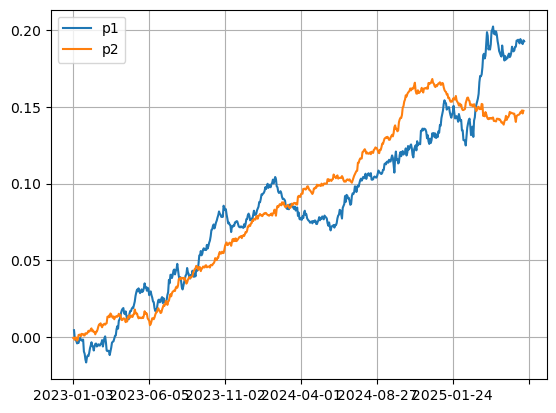

In [31]:
group_return = pd.DataFrame(cal_group_return(factor_gp, 3)).T.shift(1)
p1_index = [x for x in group_return.index if x.endswith('p1')]
p2_index = [x for x in group_return.index if x.endswith('p2')]
group_return_p1 = group_return.loc[p1_index]
group_return_p2 = group_return.loc[p2_index]
s1 = (group_return_p1['group'+str(1)] - group_return_p1['benchmark']).cumsum()
s2 = (group_return_p2['group'+str(1)] - group_return_p2['benchmark']).cumsum()
s1.index = [x[:-2] for x in s1.index]
s2.index = [x[:-2] for x in s2.index]
s1.name = 'p1'
s2.name = 'p2'
s3 = pd.concat([s1, s2], names=['p1','p2'], axis=1)
s3.plot()
plt.grid(True)

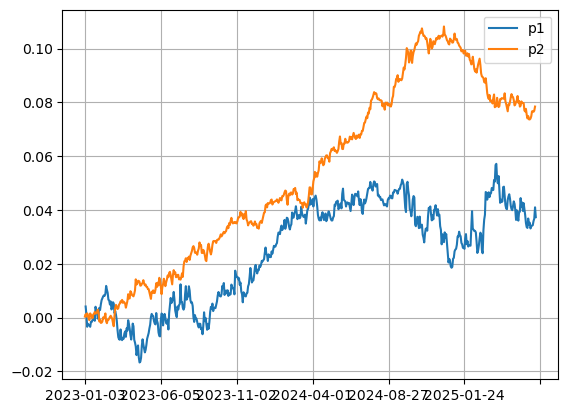

In [634]:
group_return = pd.DataFrame(cal_group_return(factor_gp, 3)).T.shift(1)
p1_index = [x for x in group_return.index if x.endswith('p1')]
p2_index = [x for x in group_return.index if x.endswith('p2')]
group_return_p1 = group_return.loc[p1_index]
group_return_p2 = group_return.loc[p2_index]
s1 = (group_return_p1['group'+str(3)] - group_return_p1['benchmark']).cumsum()
s2 = (group_return_p2['group'+str(3)] - group_return_p2['benchmark']).cumsum()
s1.index = [x[:-2] for x in s1.index]
s2.index = [x[:-2] for x in s2.index]
s1.name = 'p1'
s2.name = 'p2'
s3 = pd.concat([s1, s2], names=['p1','p2'], axis=1)
s3.plot()
plt.grid(True)

In [43]:
combined_factor = {}
c1 = pd.DataFrame(factor_std(factor_dict(combined_factor_GP_P1))).T
c2 = pd.DataFrame(factor_std(factor_dict(combined_factor_GP_P2))).T
for i in combined_factor_GP_P1.index:
    if i.endswith('p1'):
        combined_factor[i] = c2.loc[i]
    if i.endswith('p2'):
        combined_factor[i] = c1.loc[i]
combined_factor = pd.DataFrame(combined_factor).T

In [44]:
factor_analyse_turnover(combined_factor)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.492847 -0.569729 -0.472168 -0.462271 -0.526530 -0.464268   
多头年化超额（换手）  0.118102  0.074283  0.036586  0.173524  0.111212  0.031037   
多头超额胜率（换手）  0.585434  0.607843  0.579832  0.601626  0.658537  0.601626   
日均换手率       1.200653  1.444792  1.291444  1.250372  1.446687  1.286034   
概率1         0.747851  0.753582  0.780802  0.817391  0.786957  0.743478   
概率2         0.541547  0.544413  0.654728  0.591304  0.613043  0.543478   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.285285 -0.568429 -0.427901  
多头年化超额（换手）  0.079663  0.104480  0.033806  
多头超额胜率（换手）  0.532110  0.633028  0.532110  
日均换手率       1.200052  1.446490  1.280518  
概率1         0.544554  0.732673  0.683168  
概率2         0.410891  0.782178  0.638614

<Axes: >

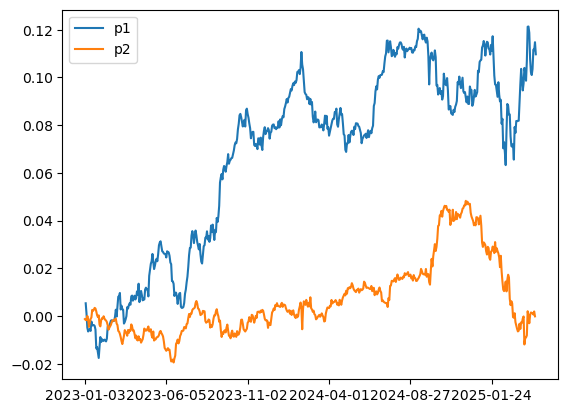

In [212]:
group_return = pd.DataFrame(cal_group_return(factor_gp, 3)).T.shift(1)
p1_index = [x for x in group_return.index if x.endswith('p1')]
p2_index = [x for x in group_return.index if x.endswith('p2')]
group_return_p1 = group_return.loc[p1_index]
group_return_p2 = group_return.loc[p2_index]
s1 = (group_return_p1['group'+str(1)] - group_return_p1['benchmark']).cumsum()
s2 = (group_return_p2['group'+str(1)] - group_return_p2['benchmark']).cumsum()
s1.index = [x[:-2] for x in s1.index]
s2.index = [x[:-2] for x in s2.index]
s1.name = 'p1'
s2.name = 'p2'
s3 = pd.concat([s1, s2], names=['p1','p2'], axis=1)
s3.plot()